# Libs

In [ ]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error, explained_variance_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

# Code

## Config

In [ ]:
SEED = 42

# YFinace
TICKERS = 'DIS'
START_DATE = '2000-01-01'
END_DATE = '2025-01-01'

# Data
DAYS = 60
TEST_SIZE = 0.2

# Model
DROPOUT_RATE = 0.2

# Train
EPOCHS = 50
BATCH_SIZE = 32

## Data

In [ ]:
data = yf.download(tickers=TICKERS, start=START_DATE, end=END_DATE, multi_level_index=False)

In [ ]:
data.info()

## Data Pre processor

In [ ]:
data = data[['Close']]

scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)

x, y = [], []
for i in range(DAYS, len(data_scaled)):
	x.append(data_scaled[i-DAYS:i, 0])
	y.append(data_scaled[i, 0])

x, y = np.array(x), np.array(y)
x = np.reshape(x, (x.shape[0], x.shape[1], 1))
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=TEST_SIZE, random_state=SEED)

## Model

In [ ]:
model = Sequential([
	LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)),
	Dropout(DROPOUT_RATE),
	LSTM(units=50, return_sequences=False),
	Dropout(DROPOUT_RATE),
	Dense(units=25, activation='relu'),
	Dense(units=1)
])
model.compile(optimizer='adam', loss='mean_squared_error')

## Train

In [ ]:
history = model.fit(x_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(x_test, y_test))

## Predict

In [ ]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions.reshape(-1, 1))
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

## Metrics

In [ ]:
mse = mean_squared_error(y_test_actual, predictions)
mae = mean_absolute_error(y_test_actual, predictions)
r2 = r2_score(y_test_actual, predictions)
mape = mean_absolute_percentage_error(y_test_actual, predictions)
ev_score = explained_variance_score(y_test_actual, predictions)

print(f'MSE: {mse}')
print(f'MAE: {mae}')
print(f'R2: {r2}')
print(f'MAPE: {mape}')
print(f'EV: {ev_score}')

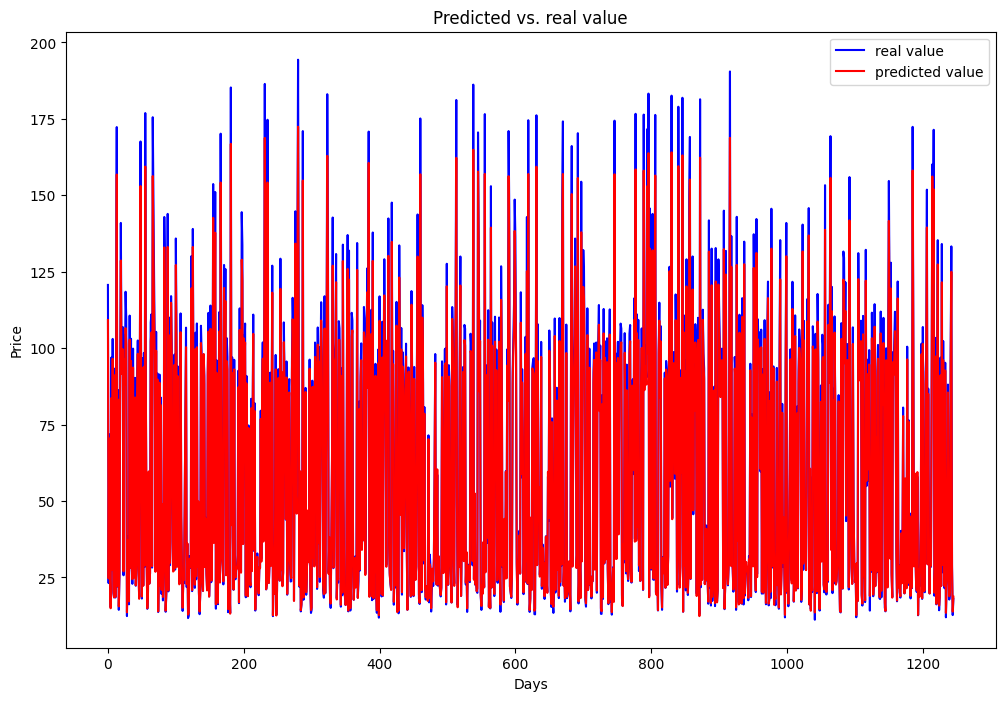

In [11]:
plt.figure(figsize=(12, 8))
plt.plot(y_test_actual, color='blue', label='real value')
plt.plot(predictions, color='red', label='predicted value')
plt.title('Predicted vs. real value')
plt.xlabel('Days')
plt.ylabel('Price')
plt.legend()
plt.show()

## Save model

In [13]:
model.save('model.keras')